# Preparing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataset_folder = "/content/drive/MyDrive/dailything"

train_split_percent = 80

processed_images_path = '/content/drive/MyDrive/dailything'
train_path = '/content/train'
test_path = '/content/test'

target_size = 400

model_save_directory = "/content/drive/MyDrive/new_models"
model_file_name = "efficientnet_B7.h5"
['acremote','bottol','key','mobilecharger','laptop'] 
folder_labels = {
    "Remote" : "acremote",
    "Water bottel" : "bottol",
    "Lock Key" : "key",
    "Charger" : "mobilecharger",
    "Laptop" : "laptop",
}

In [ ]:
import os

model_save_path = os.path.join(model_save_directory,model_file_name)

# Pre-Processing

In [ ]:
# Current directory should be /dataset
import os
from skimage import io, color
dataset_directory = os.path.join(os.getcwd(),dataset_folder)
for m_folder in os.listdir(dataset_directory):
  if m_folder not in folder_labels:
    continue
  category_name = folder_labels[m_folder]
  sub_folder_path = os.path.join(dataset_directory,m_folder)
  for m_file in os.listdir(sub_folder_path):
    in_path = os.path.join(sub_folder_path,m_file)
    out_path = os.path.join(processed_images_path,category_name,m_file)
    try:
      i1 = io.imread(in_path)
    except:
      print(in_path)
      continue
    io.imsave(out_path, i1)
print("Pre-Processing completed.")

Pre-Processing completed.


# Dataset loading and augmenting

In [ ]:
from keras.models import Sequential
from keras import layers
import tensorflow as tf

img_augmentation = Sequential(
    [
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(0.3,0.3),
        layers.RandomRotation(360),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomContrast(factor=0.1),
    ],
)

In [ ]:
%cd '/content'
!rm -rf './processed/.ipynb_checkpoints'

/content


In [ ]:
input_shape = (target_size,target_size,3)
batch_size = 32 #@param {type:"slider", min:1, max:256, step:1}
seed = 1607 #@param {type:"slider", min:1, max:10000, step:1}


train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/dailything",
    label_mode='categorical',
    validation_split=0.2,
    subset="both",
    seed=1607,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)

aug_train_ds = train_ds.map(
  lambda x, y: (img_augmentation(x, training=True), y))

aug_val_ds = val_ds.map(
  lambda x, y: (img_augmentation(x, training=True), y))

Found 192 files belonging to 5 classes.
Using 154 files for training.
Using 38 files for validation.


# Helper functions

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

# Using EfficientNet

In [ ]:
from keras.applications import EfficientNetB7

In [ ]:
n_classes = len(train_ds.class_names)
print(train_ds.class_names)

['acremote', 'bottol', 'key', 'laptop', 'mobilecharger']


In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(target_size, target_size, 3))
    x = inputs
    model = EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet_B7")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(n_classes)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# ckpt = ModelCheckpoint(filepath=model_save_path,monitor='val_accuracy',verbose=1,save_best_only=True)
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=10,verbose=1)

# cb = [ckpt,es]
cb = [es]

Check if all dataset images are in jpeg formate


In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/dailything/mobilecharger"
image_extensions = [".png", ".jpeg"] 

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")


In [ ]:
# @title Train the model
steps = 10 
validation_steps = 3 
epochs = 50
hist = model.fit(aug_train_ds.repeat(), steps_per_epoch=steps,validation_data=aug_val_ds.repeat(),validation_steps=validation_steps, epochs=epochs, callbacks=cb)

Epoch 1/50
10/10 [==============================] - 82s 6s/step - loss: 0.9476 - accuracy: 0.6656 - val_loss: 0.9074 - val_accuracy: 0.9143
Epoch 2/50
10/10 [==============================] - 41s 4s/step - loss: 0.1129 - accuracy: 0.9545 - val_loss: 0.6496 - val_accuracy: 0.9571
Epoch 3/50
10/10 [==============================] - 37s 4s/step - loss: 0.0578 - accuracy: 0.9870 - val_loss: 0.5811 - val_accuracy: 0.9571
Epoch 4/50
10/10 [==============================] - 35s 4s/step - loss: 0.0476 - accuracy: 0.9870 - val_loss: 0.4830 - val_accuracy: 0.9286
Epoch 5/50
10/10 [==============================] - 34s 4s/step - loss: 0.0329 - accuracy: 0.9903 - val_loss: 0.4651 - val_accuracy: 0.9571
Epoch 6/50
10/10 [==============================] - 59s 6s/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.3536 - val_accuracy: 0.9714
Epoch 7/50
10/10 [==============================] - 35s 4s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.3160 - val_accuracy: 1.0000
Epoch 8/50
10/10 [==

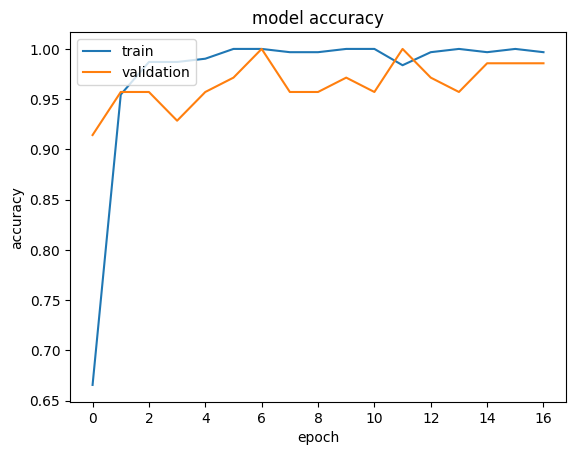

In [ ]:
plot_hist(hist)

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[:20]:
        is_batch_norm = isinstance(layer, layers.BatchNormalization)
        is_activation = isinstance(layer, layers.Activation)
        if is_batch_norm or is_activation:
          continue
        layer.trainable = True


    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 40  # @param {type: "slider", min:1, max:50}
steps = 10  # @param {type: "slider", min:1, max:20}
validation_steps = 2  # @param {type: "slider", min:0, max:10}
hist = model.fit(train_ds.repeat(), steps_per_epoch=steps,validation_data=val_ds.repeat(),validation_steps=validation_steps, epochs=epochs, callbacks=cb)
plot_hist(hist)

# Test the model

In [ ]:
# train_ds.class_names
classes = ['acremote','bottol','key','mobilecharger','laptop'] 

In [ ]:
paths = {
    "/content/acremote.jpeg" : 0,
    "/content/bottel.jpeg"                              : 1,
    "/content/key.jpeg"                      : 2,
    "/content/mobilecharger.jpeg"             : 3,
    "/content/laptop.jpeg"                  : 4,
}

In [ ]:
import cv2

def get_class_name(img_path: str):
  target_dims = (target_size,target_size)

  img = cv2.imread(img_path)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, target_dims)
  # img = img/255.0

  # img = img.reshape((1,*target_dims,3))

  pred = model.predict(
      np.array([img])
      )
  # print(pred)

  idx = pred.argmax()
  print(classes[idx])
  return classes[idx]

In [ ]:
res = [
    get_class_name(path_name)
    for path_name in paths
]

1/1 [==============================] - 0s 67ms/step
[[0.93123484 0.01004174 0.01821818 0.02523981 0.01526551]]
acremote
1/1 [==============================] - 0s 73ms/step
[[0.00332541 0.97782236 0.00230015 0.01162222 0.00492995]]
bottol
1/1 [==============================] - 0s 62ms/step
[[0.00850986 0.01591729 0.92690897 0.01299971 0.03566424]]
key
1/1 [==============================] - 0s 65ms/step
[[0.00906059 0.01836475 0.0145159  0.04840096 0.90965784]]
laptop
1/1 [==============================] - 0s 63ms/step
[[0.00163781 0.00897714 0.0124137  0.9672666  0.00970469]]
mobilecharger


In [ ]:
values = tuple(paths.values())

for idx in range(len(res)):
  print("Expected :",classes[values[idx]],"  || GOT : ",res[idx])

Expected : acremote   || GOT :  acremote
Expected : bottol   || GOT :  bottol
Expected : key   || GOT :  key
Expected : mobilecharger   || GOT :  laptop
Expected : laptop   || GOT :  mobilecharger
